In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import yaml
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

from src.data.prepare_data import prepare_data
from src.models.utils import imbalanced_sampling, set_global_seed

In [ ]:
# read config
with open("../config.yml", "r") as file:
    config=yaml.load(file, Loader= yaml.SafeLoader)
del file

# ensure reproducibility
set_global_seed(seed=config["general"]["seed"])

# parameters
N_TRIALS = 3
EPOCHS = 10
BATCH_SIZE = 32

In [ ]:
# load and prepare data
df = pd.read_csv("../" + config["data_loader"]["path"])
df = prepare_data(df=df)
display(df.head())

# check class distributions
df["label"].value_counts(normalize=True)

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,label
0,-1.996580,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,-1.996580,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342474,0
2,-1.996558,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160684,0
3,-1.996558,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.996537,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


label
0    0.998273
1    0.001727
Name: proportion, dtype: float64

**Train and Test Set**
- Split whole set into train and test sets using strat sampling
- Apply oversampling as the number of positive instances is small

In [ ]:
# split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[:,:-1], df["label"]
    , test_size=config["train_test_split"]["test_size"]
    , random_state=123
    , shuffle=True
    , stratify=df["label"]
    )

In [ ]:
# apply oversampling to the train set
X_train_rs, y_train_rs = imbalanced_sampling(
    method="over"
    , X_train=X_train
    , y_train=y_train
)

# check class distributions
print(
    y_train.value_counts(normalize=True)
    , y_train_rs.value_counts(normalize=True)
    )

label
0    0.998274
1    0.001726
Name: proportion, dtype: float64 label
0    0.5
1    0.5
Name: proportion, dtype: float64


**Optimization**
- Perform hyper-param tuning through bayesian search
- Train and Evaluate model

In [ ]:
def model_builder(hp):
  model = keras.models.Sequential()
  model.add(keras.Input(shape=(30,)))

  n_layers = hp.Int("n_layers", min_value=4, max_value=8, step=1)
  for i in range(n_layers):
    hp_units = hp.Int(f"units_{i}", min_value=32, max_value=128, step=4)
    hp_activation = hp.Choice(f"activation_{i}", values=["sigmoid", "relu"])
    model.add(keras.layers.Dense(units=hp_units, activation=hp_activation))
  # output layer
  model.add(keras.layers.Dense(units=1, activation="sigmoid"))

  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
    )

  return model

In [7]:
bayesian_search_tuner = kt.BayesianOptimization(
    hypermodel=model_builder,
    objective="val_accuracy",
    max_trials=N_TRIALS,
    executions_per_trial=1,
    seed=config["general"]["seed"],
    overwrite=False
    #, directory=
    , project_name="keras_tuner"

)

bayesian_search_tuner.search(
    X_train_rs.to_numpy(), y_train_rs.to_numpy(),
    epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2
)

Trial 3 Complete [00h 09m 42s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 28m 30s


In [8]:
bayesian_search_tuner.results_summary()

Results summary
Results in .\keras_tuner
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
n_layers: 7
units_0: 32
activation_0: sigmoid
units_1: 56
activation_1: relu
units_2: 64
activation_2: relu
units_3: 36
activation_3: sigmoid
units_4: 32
activation_4: sigmoid
units_5: 32
activation_5: sigmoid
units_6: 32
activation_6: sigmoid
Score: 1.0

Trial 1 summary
Hyperparameters:
n_layers: 5
units_0: 128
activation_0: relu
units_1: 120
activation_1: sigmoid
units_2: 128
activation_2: sigmoid
units_3: 88
activation_3: sigmoid
units_4: 60
activation_4: sigmoid
units_5: 124
activation_5: sigmoid
units_6: 76
activation_6: sigmoid
Score: 1.0

Trial 2 summary
Hyperparameters:
n_layers: 4
units_0: 36
activation_0: relu
units_1: 100
activation_1: relu
units_2: 64
activation_2: sigmoid
units_3: 56
activation_3: relu
units_4: 76
activation_4: sigmoid
units_5: 108
activation_5: relu
units_6: 44
activation_6: sigmoid
Score: 1.0


In [9]:
# get best model and retrain on whole training set
best_hps = bayesian_search_tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = bayesian_search_tuner.hypermodel.build(best_hps)

history = best_model.fit(
    X_train_rs.to_numpy(), y_train_rs.to_numpy(),
    epochs=30,
    batch_size=BATCH_SIZE,
    validation_data=(X_test.to_numpy(), y_test.to_numpy())
)

# test set evaluation
best_model.evaluate(X_test.to_numpy(), y_test.to_numpy())

Epoch 1/30
16882/16882 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - accuracy: 0.9625 - loss: 0.1047 - val_accuracy: 0.9961 - val_loss: 0.0200
Epoch 2/30
16882/16882 ━━━━━━━━━━━━━━━━━━━━ 114s 4ms/step - accuracy: 0.9940 - loss: 0.0295 - val_accuracy: 0.9983 - val_loss: 0.0127
Epoch 3/30
16882/16882 ━━━━━━━━━━━━━━━━━━━━ 96s 5ms/step - accuracy: 0.9953 - loss: 0.0256 - val_accuracy: 0.9982 - val_loss: 0.0136
Epoch 4/30
16882/16882 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - accuracy: 0.9957 - loss: 0.0243 - val_accuracy: 0.9983 - val_loss: 0.0140
Epoch 5/30
16882/16882 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.9963 - loss: 0.0205 - val_accuracy: 0.9985 - val_loss: 0.0072
Epoch 6/30
16882/16882 ━━━━━━━━━━━━━━━━━━━━ 78s 5ms/step - accuracy: 0.9990 - loss: 0.0047 - val_accuracy: 0.9986 - val_loss: 0.0064
Epoch 7/30
16882/16882 ━━━━━━━━━━━━━━━━━━━━ 73s 4ms/step - accuracy: 0.9993 - loss: 0.0035 - val_accuracy: 0.9984 - val_loss: 0.0076
Epoch 8/30
16882/16882 ━━━━━━━━━━━━━━━━━━━━ 81s 5ms/step - accuracy:

[0.006160400342196226, 0.9991573691368103]

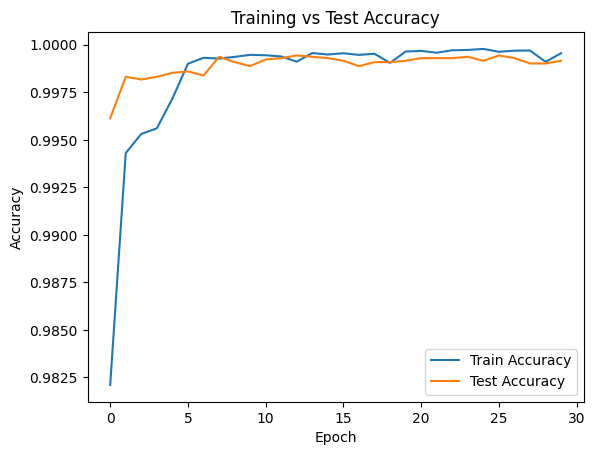

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Test Accuracy")
plt.show()